In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from IPython.display import HTML, display
import numpy as np
import dataframe_image as dfi
import json
import seaborn as sns
import warnings
from IPython.display import HTML, display, Markdown

from utils.diagnostics import compute_summary_statistics
from utils.dataset_utils import aggregate_results

plt.style.use('bmh')
plt.rcParams['lines.linewidth'] = 1

In [21]:
results_path = os.path.join(os.getcwd(), "results")
data_path = os.path.join(os.getcwd(), "data", "inputs")

model_group = ["mvo", "rpo", "rbmvo", "rbmvog", "cmvo", "grbcmvo", "rbcmvo"]
estimator_group = ["mle", "nobb", "cbb", "sb"]
percentile_group = ["95"] #, "5"]

model_names = [

    "ew_lo", 

    "mvo_lo_mle_mle", 

    "cmvo_silhouette_lo_mle_mle", 

    "rpo_lo_mle_mle_cs2006", 
    
    "bmvo_lo_nobb_nobb_95", "bmvo_lo_cbb_cbb_95", "bmvo_lo_sb_sb_95",
    "bmvo_lo_nobb_nobb_75", "bmvo_lo_cbb_cbb_75", "bmvo_lo_sb_sb_75",
    "bmvo_lo_nobb_nobb_25", "bmvo_lo_cbb_cbb_25", "bmvo_lo_sb_sb_25",

    "bumvo_lo_nobb_nobb_95", "bumvo_lo_cbb_cbb_95", "bumvo_lo_sb_sb_95",
    "bumvo_lo_nobb_nobb_75", "bumvo_lo_cbb_cbb_75", "bumvo_lo_sb_sb_75",
    "bumvo_lo_nobb_nobb_25", "bumvo_lo_cbb_cbb_25", "bumvo_lo_sb_sb_25",

    "bucmvo_silhouette_lo_nobb_nobb_95", "bucmvo_silhouette_lo_cbb_cbb_95", "bucmvo_silhouette_lo_sb_sb_95",
    "bucmvo_silhouette_lo_nobb_nobb_75", "bucmvo_silhouette_lo_cbb_cbb_75", "bucmvo_silhouette_lo_sb_sb_75",
    "bucmvo_silhouette_lo_nobb_nobb_25", "bucmvo_silhouette_lo_cbb_cbb_25", "bucmvo_silhouette_lo_sb_sb_25",
    
    # "bcumvo_silhouette_lo_nobb_95", "bcumvo_silhouette_lo_cbb_95", "bcumvo_silhouette_lo_sb_95",
    # "bcumvo_silhouette_lo_nobb_75", "bcumvo_silhouette_lo_cbb_75", "bcumvo_silhouette_lo_sb_75",
    # "bcumvo_silhouette_lo_nobb_25", "bcumvo_silhouette_lo_cbb_25", "bcumvo_silhouette_lo_sb_25",
]
stats_order = ["E[R]", "Std(R)", "Sharpe", "Sortino", "AvgDD", "MaxDD", "% Positive Ret."]

vol_target = 0.2

In [22]:
model_des1 = {
    
    "ew": "Equal Weight Portfolio",
    "mvo": "Mean-Variance Optimization",
    "rpo": "Robust Portfolio Optimization",
    "brpo": "Bootstrap Robust Portfolio Optimization",
    "bmvo": "Bootstrap Robust Mean-Variance Optimization",
    "bumvo": "Bootstrap Utility Robust Mean-Variance Optimization",
    "cmvo": "Cluster (SPONGE) Mean-Variance Optimization",
    "bucmvo": "Bootstrap Utility Robust Mean-Variance Optimization with Cluster (SPONGE)",
    "bcumvo": "Bootstrap Utility Double Robust Mean-Variance Optimization with Cluster (SPONGE)",

}

model_des2 = {
    
    "cs2006": "Robust Portfolio Optimization proposed by Cerias and Stubbs (2006)",
    "y2022": "Robust Portfolio Optimization proposed by Yang (2022)",

}

estimators = {

    "mle": "Maximum Likelihood Estimation",
    "nobb": "Non-overlapping Block Bootstrap",
    "cbb": "Circular Block Bootstrap",
    "sb": "Stationary Bootstrap",

}

percentiles_boot_dist = {

    "95": "95th Percentile",
    "75": "75th Percentile",
    "25": "25th Percentile",
    
}

portfolio_constraints = {

    "lo": "Long-Only",
    "ls": "Long-Short",

}

## 0) Dataset description

In [23]:
data

,SPY,IWM,EEM,TLT,USO,GLD,XLF,XLB,XLK,XLV,...,XLU,XLY,XLP,XLE,VIX,AGG,DBC,HYG,LQD,UUP
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,145.4375,NaN,NaN,NaN,NaN,NaN,18.5749,25.9688,55.4375,30.2969,...,27.4531,30.1250,22.7500,26.5625,24.21,NaN,NaN,NaN,NaN,NaN
2000-01-04,139.7500,NaN,NaN,NaN,NaN,NaN,17.7629,25.7188,52.6250,29.6094,...,26.6250,29.2188,22.1094,26.0625,27.01,NaN,NaN,NaN,NaN,NaN
2000-01-05,140.0000,NaN,NaN,NaN,NaN,NaN,17.6233,26.7813,51.8438,29.3438,...,27.2969,28.8594,22.5000,26.7500,26.41,NaN,NaN,NaN,NaN,NaN
2000-01-06,137.7500,NaN,NaN,NaN,NaN,NaN,18.3973,27.4688,50.1250,29.4375,...,27.2500,29.1875,22.9219,27.7813,25.73,NaN,NaN,NaN,NaN,NaN
2000-01-07,145.7500,NaN,NaN,NaN,NaN,NaN,18.7018,27.4531,51.0000,29.7969,...,27.4844,30.5625,24.3750,28.0781,21.72,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-16,450.2300,175.88,39.31,89.62,68.05,183.69,34.8300,80.1200,183.1800,128.5100,...,62.1200,166.0300,69.5800,82.9500,14.32,95.06,23.61,74.60,104.09,29.46
2023-11-17,450.7900,178.29,39.36,90.04,70.75,183.67,35.0100,80.2700,182.8000,128.2500,...,62.2900,167.1400,69.4900,84.6900,13.80,95.25,23.95,74.77,104.39,29.30
2023-11-20,454.2600,179.33,39.85,90.59,72.30,183.37,35.1500,80.4100,185.4500,129.0300,...,62.1000,168.0000,69.4400,84.8100,13.41,95.40,24.25,74.85,104.81,29.21


In [24]:
data = pd.read_csv(os.path.join(data_path, "etfs.csv"), sep=";")
data.loc[:, "date"] = pd.to_datetime(data["date"])
data.set_index("date", inplace=True)

/nfs/home/danielc/miniconda3/envs/npbrs/lib/python3.10/site-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [25]:
data.shape

(6233, 21)

In [26]:
data.isnull().any()

SPY    False
IWM     True
EEM     True
TLT     True
USO     True
GLD     True
XLF    False
XLB    False
XLK    False
XLV    False
XLI    False
XLU    False
XLY    False
XLP    False
XLE    False
VIX    False
AGG     True
DBC     True
HYG     True
LQD     True
UUP     True
dtype: bool

In [27]:
data.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
SPY,6233.0,196.12,104.47,68.11,119.27,145.64,255.79,477.71
IWM,6129.0,102.58,51.23,32.55,61.08,82.13,141.94,242.56
EEM,5379.0,38.18,9.27,11.08,34.56,40.11,43.76,57.96
TLT,5564.0,110.60,21.06,80.65,91.24,107.72,123.66,171.57
USO,4598.0,220.72,174.88,17.04,81.52,162.20,301.76,939.84
GLD,4960.0,121.95,38.91,41.26,96.50,121.86,157.20,193.89
XLF,6233.0,22.15,7.32,5.02,17.52,22.13,26.86,41.42
XLB,6233.0,43.00,18.67,16.63,28.03,39.18,53.68,90.61
XLK,6233.0,50.67,42.59,11.58,21.86,30.22,63.30,185.45
XLV,6233.0,58.03,35.21,21.88,30.12,36.16,82.00,142.83


In [28]:
print(data.describe().T.round(4).to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
 & count & mean & std & min & 25% & 50% & 75% & max \\
\midrule
SPY & 6233.000000 & 196.117400 & 104.467300 & 68.110000 & 119.270000 & 145.642000 & 255.790000 & 477.710000 \\
IWM & 6129.000000 & 102.577200 & 51.229500 & 32.550000 & 61.075000 & 82.130000 & 141.940000 & 242.560000 \\
EEM & 5379.000000 & 38.179300 & 9.271300 & 11.077800 & 34.560000 & 40.110000 & 43.755000 & 57.960000 \\
TLT & 5564.000000 & 110.603100 & 21.056900 & 80.650000 & 91.235000 & 107.715000 & 123.660000 & 171.570000 \\
USO & 4598.000000 & 220.720900 & 174.878200 & 17.040000 & 81.520000 & 162.200000 & 301.760000 & 939.840000 \\
GLD & 4960.000000 & 121.951600 & 38.906800 & 41.260000 & 96.500000 & 121.860000 & 157.202500 & 193.890000 \\
XLF & 6233.000000 & 22.147400 & 7.323800 & 5.018300 & 17.523300 & 22.127500 & 26.860000 & 41.420000 \\
XLB & 6233.000000 & 43.000300 & 18.667200 & 16.630000 & 28.030000 & 39.180000 & 53.680000 & 90.610000 \\
XLK & 6233.000000 & 50.667000 & 42.593900

## 1) Summary Statistics of the Portfolios

In [29]:
all_summary = []

for model in model_names:

        output_path = os.path.join(os.getcwd(),
                                   "data",
                                   "outputs",
                                   model)
    
        try:
            summary = aggregate_results(path=output_path)
        except:
            print(f"Error: {model}")
            continue

        # read json
        args = json.load(open(os.path.join(output_path, "args.json")))
        args_df = pd.DataFrame.from_dict(args, orient="index", columns=["value"]).T
        args_df.drop(["model_name"], axis=1, inplace=True)

        for col in args_df.columns:
            if col != 'mean_cov_estimator':
                summary[col] = args_df[col].iloc[0]
            else:
                summary['mean_estimator'] = args_df[col].iloc[0]
                summary['covariance_estimator'] = args_df[col].iloc[0]


        # compute pnl
        summary["pnl"] = summary["returns"] * summary["weights"]

        # add model name
        summary["id"] = model

        # save summary
        all_summary.append(summary)
all_summary_df = pd.concat(all_summary, axis=0)

Error: bucmvo_silhouette_lo_nobb_nobb_95
Error: bucmvo_silhouette_lo_cbb_cbb_95
Error: bucmvo_silhouette_lo_nobb_nobb_75
Error: bucmvo_silhouette_lo_nobb_nobb_25
Error: bucmvo_silhouette_lo_sb_sb_25


In [30]:

all_stats = {}
all_stats_des = {}
for model in model_names:

    summary_df = all_summary_df.loc[all_summary_df["id"] == model]

    portfolio_returns =  summary_df.groupby("date").sum()[["pnl"]]
    portfolio_vol = (portfolio_returns.rolling(window=252).std() * np.sqrt(252)).shift(1)
    portfolio_returns_target = (portfolio_returns * (vol_target / portfolio_vol)).dropna()

    stats = compute_summary_statistics(portfolio_returns=torch.tensor(portfolio_returns_target.values))

    all_stats[model] = stats

    stats.update({"model": summary_df["model"].unique()[0], "estimator": summary_df["mean_estimator"].unique()[0]})
    all_stats_des[model] = stats
all_stats_df = pd.DataFrame(all_stats).T[stats_order]

dfi.export(all_stats_df, os.path.join(results_path, "all_stats_lo_df.png"))
display(HTML(all_stats_df.astype(float).round(4).to_html()))

/nfs/home/danielc/rpowbe/src/loss_functions/Volatility.py:14: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /opt/conda/conda-bld/pytorch_1729647176142/work/aten/src/ATen/native/ReduceOps.cpp:1823.)
  volatility = torch.std(returns) * (np.sqrt(252) if annualize else 1) * 100
/nfs/home/danielc/rpowbe/src/loss_functions/Sharpe.py:14: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /opt/conda/conda-bld/pytorch_1729647176142/work/aten/src/ATen/native/ReduceOps.cpp:1823.)
  sharpe_ratio = (torch.mean(returns) / torch.std(returns)) * (np.sqrt(252) if annualize else 1)
/nfs/home/danielc/rpowbe/src/loss_functions/Sortino.py:17: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel

IndexError: index 0 is out of bounds for dimension 0 with size 0

In [14]:
print(all_stats_df.astype(float).round(2).reset_index().to_latex(index=False))

NameError: name 'all_stats_df' is not defined

In [15]:
display(HTML(all_stats_df.sort_values("Sharpe", ascending=False).to_html()))

NameError: name 'all_stats_df' is not defined

In [16]:
display(HTML(all_stats_df.sort_values("AvgDD", ascending=False).to_html()))

NameError: name 'all_stats_df' is not defined

In [17]:
display(HTML(all_stats_df.sort_values("MaxDD", ascending=False).to_html()))

NameError: name 'all_stats_df' is not defined

In [18]:
display(HTML(all_stats_df.sort_values("% Positive Ret.", ascending=False).to_html()))

NameError: name 'all_stats_df' is not defined

## 2) Metrics Boxplots by Portfolio Selection Model and Parameter Estimator

### Sharpe by Portfolio Selection Model and Parameter Estimator

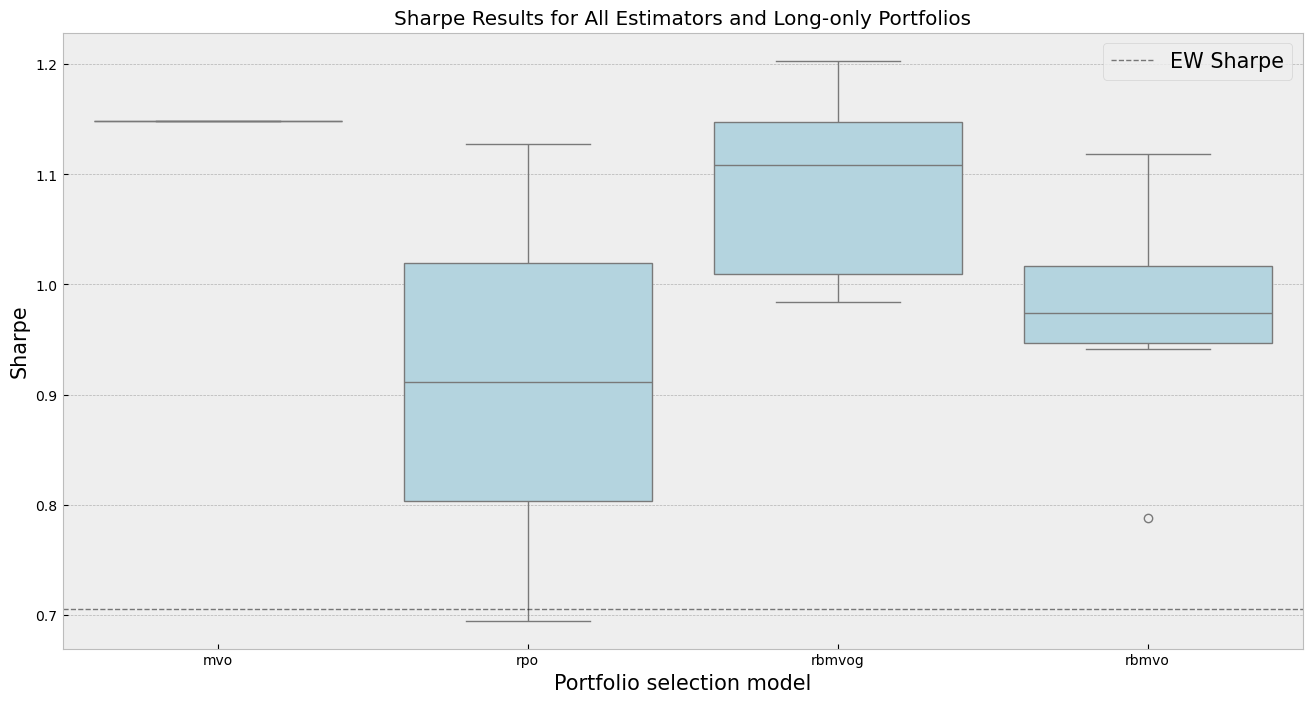

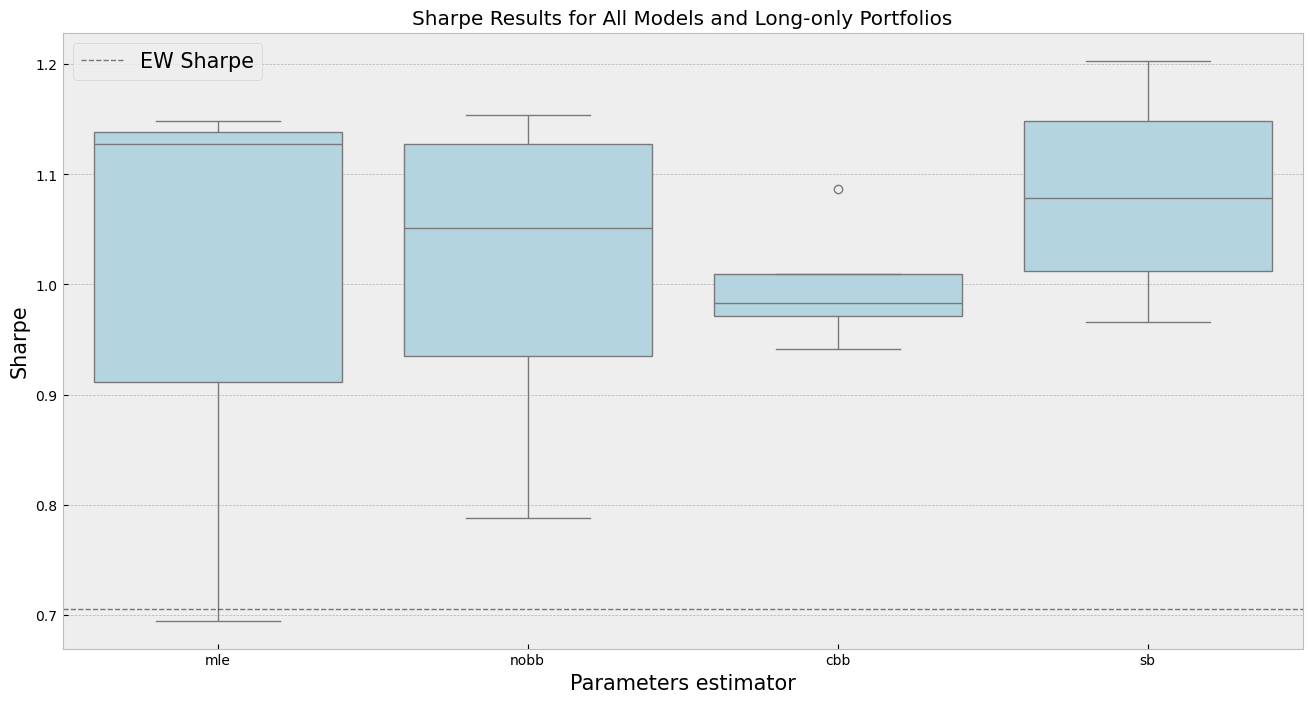

### AvgDD by Portfolio Selection Model and Parameter Estimator

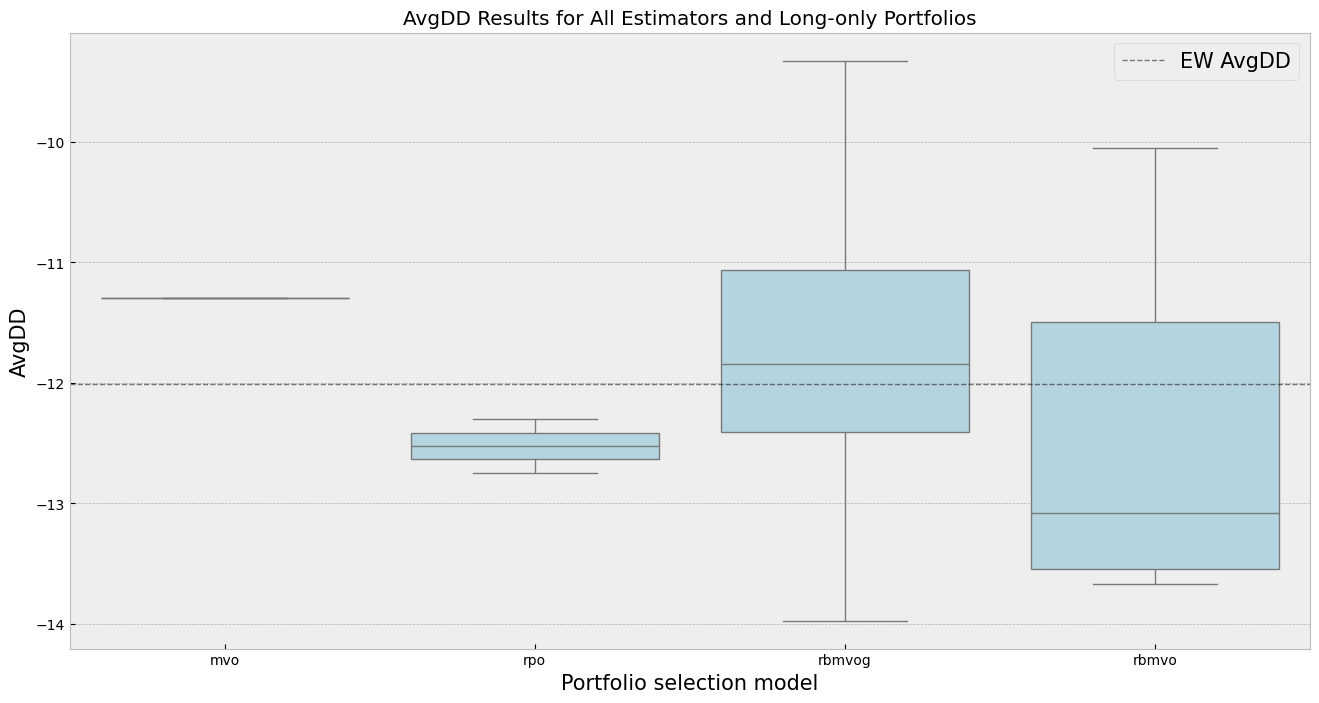

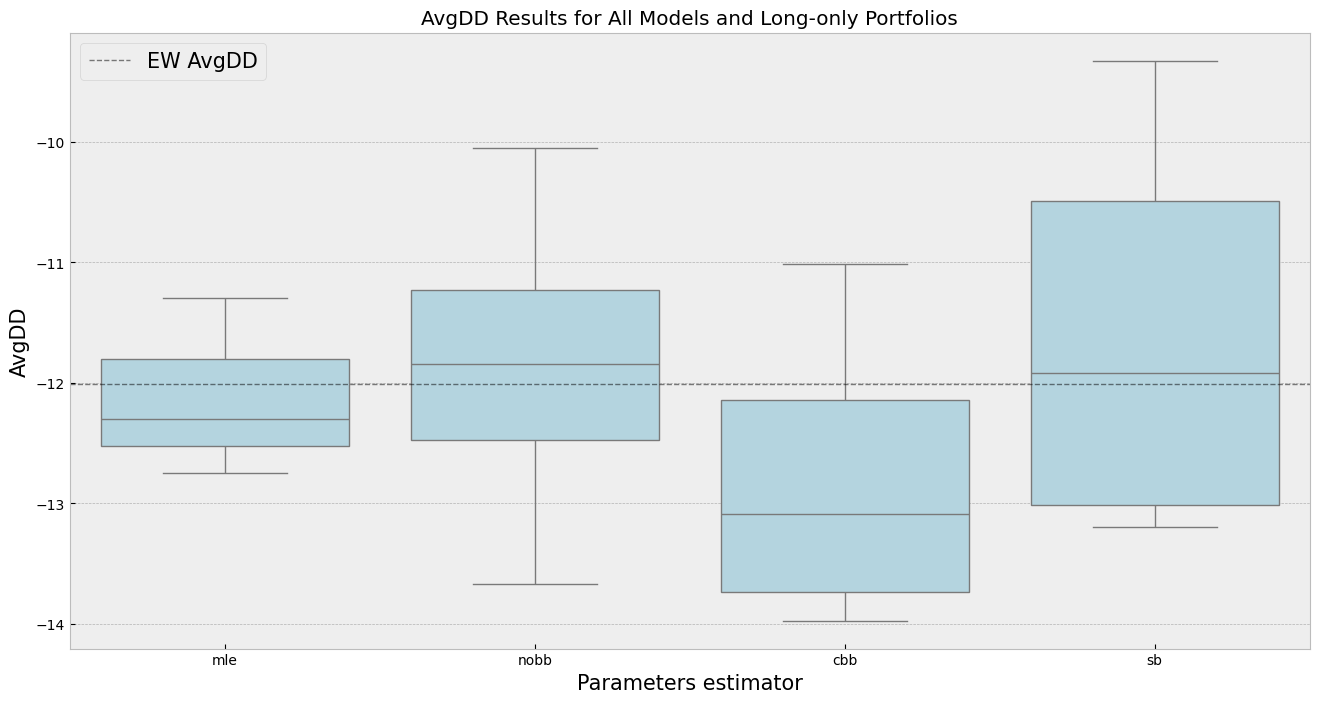

### MaxDD by Portfolio Selection Model and Parameter Estimator

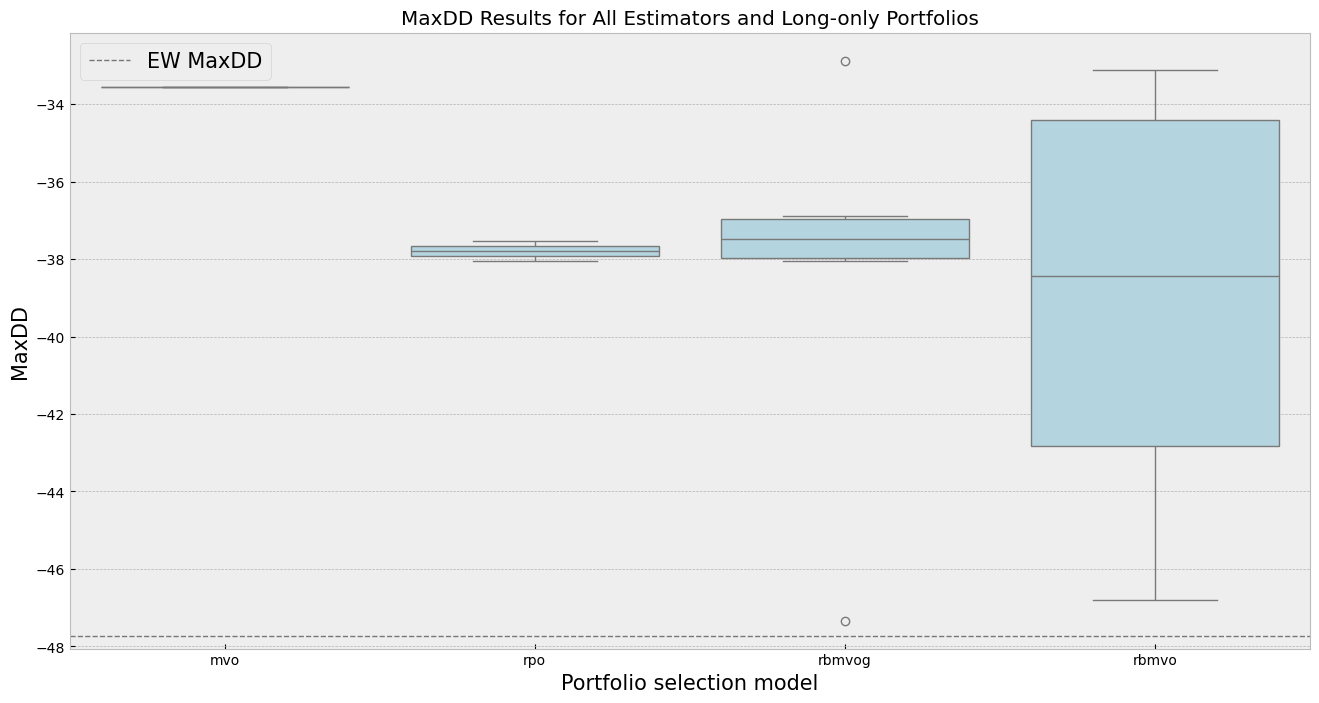

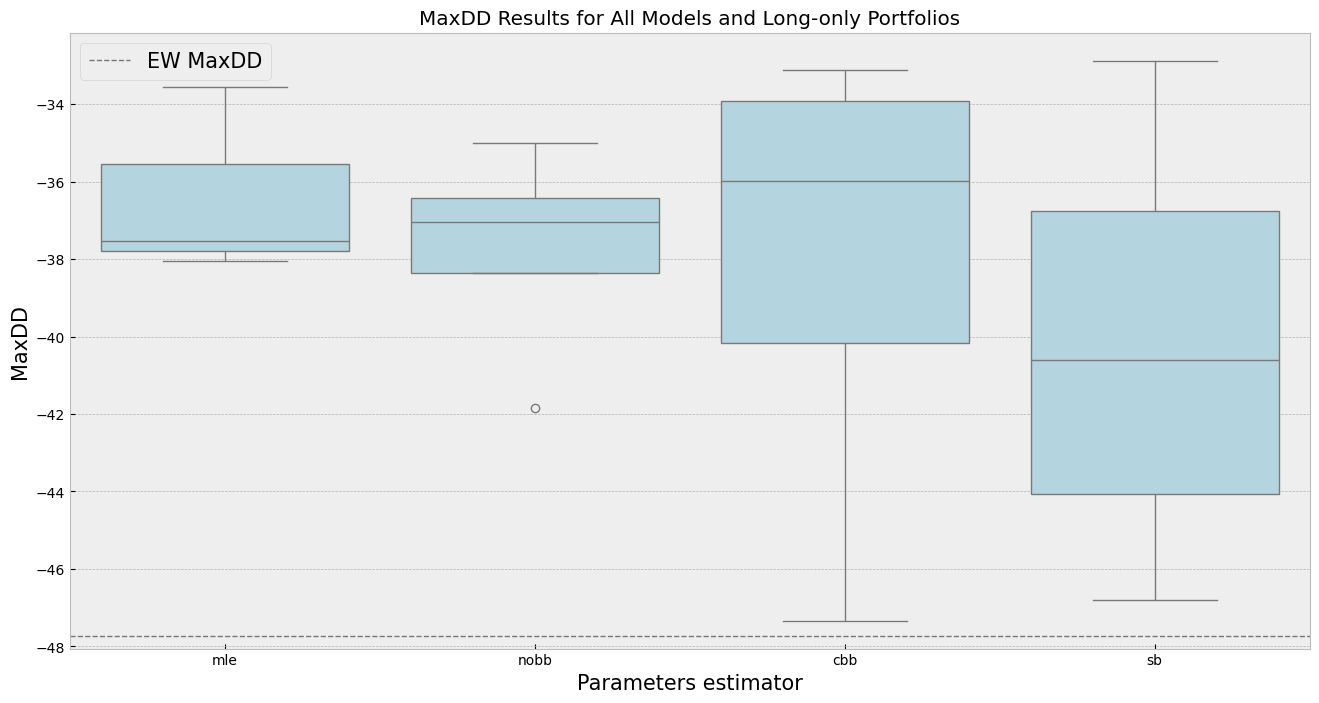

In [71]:
warnings.simplefilter("ignore")

metrics = ["Sharpe", "AvgDD", "MaxDD"]

# agg. stats with description
all_stats_des_df = pd.DataFrame(all_stats_des).T

ew_benchmark = all_stats_des_df.loc[all_stats_des_df["model"] == "ew"][metrics]
mvo_benchmark = all_stats_des_df.loc[all_stats_des_df["model"] == "mvo"][metrics]

all_stats_des_df = all_stats_des_df.dropna()

melt_all_stats_des_df = all_stats_des_df.melt(["model", "estimator"])

# compute means
model_mean = melt_all_stats_des_df.groupby(["model", "variable"]).mean()
avg_overall = melt_all_stats_des_df.groupby(["variable"])[["value"]].mean()

for m in metrics:

    plot_df = melt_all_stats_des_df.loc[melt_all_stats_des_df["variable"] == m].drop(["variable"], axis=1).rename(columns={"value": m})

    display(Markdown(f"### {m} by Portfolio Selection Model and Parameter Estimator"))
    fig, ax = plt.subplots(figsize=(16,8))
    sns.boxplot(x="model", y=m, data=plot_df, ax=ax, color='lightblue')
    ax.set_ylabel(m, fontsize=15)
    ax.set_xlabel("Portfolio selection model", fontsize=15)
    ax.axhline(y=ew_benchmark[m].iloc[0], color='k', linestyle='--', alpha=0.5, label=f"EW {m}")
    # ax.axhline(y=mvo_benchmark[m].iloc[0], color='r', linestyle='--', alpha=0.5, label=f"MVO {m}")
    ax.tick_params(axis="x", labelsize=10)
    ax.tick_params(axis="y", labelsize=10)
    ax.title.set_text(f"{m} Results for All Estimators and Long-only Portfolios")
    ax.legend(loc="best",fontsize=15)
    plt.show()
    fig.savefig(os.path.join(results_path, f"{m}_boxplot_models_lo.png"), dpi=300)

    fig, ax = plt.subplots(figsize=(16,8))
    sns.boxplot(x="estimator", y=m, data=plot_df, ax=ax, color='lightblue')
    ax.set_ylabel(m, fontsize=15)
    ax.set_xlabel("Parameters estimator", fontsize=15)
    ax.axhline(y=ew_benchmark[m].iloc[0], color='k', linestyle='--', alpha=0.5, label=f"EW {m}")
    # ax.axhline(y=mvo_benchmark[m].iloc[0], color='r', linestyle='--', alpha=0.5, label=f"MVO {m}")
    ax.tick_params(axis="x", labelsize=10)
    ax.tick_params(axis="y", labelsize=10)
    ax.title.set_text(f"{m} Results for All Models and Long-only Portfolios")
    ax.legend(loc="best",fontsize=15)
    plt.show()
    fig.savefig(os.path.join(results_path, f"{m}_boxplot_estimators_lo.png"), dpi=300)


## 3) Cummulative Returns of the Portfolios

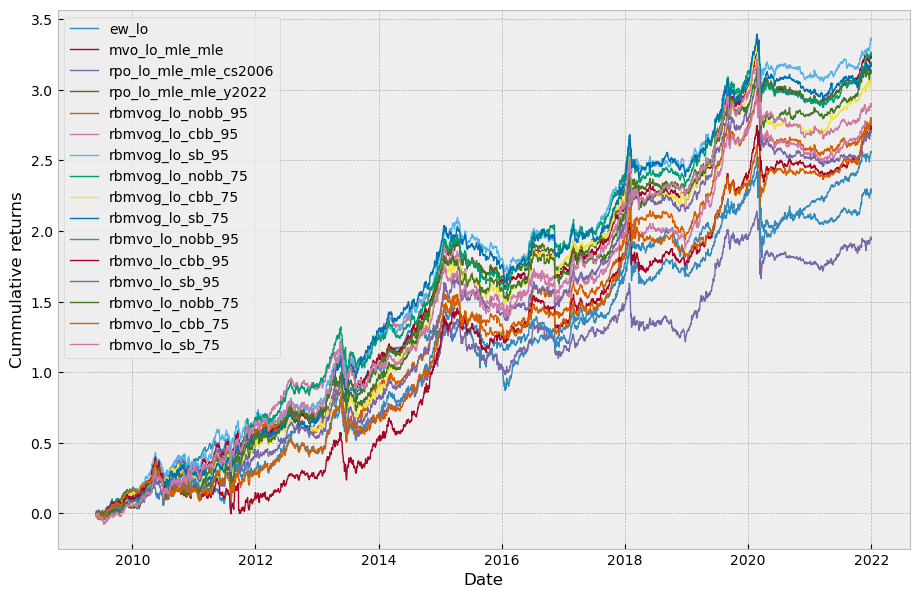

In [72]:
fig, ax = plt.subplots(figsize=(11, 7))
for model in model_names:
    summary_df = all_summary_df.loc[all_summary_df["id"] == model]

    portfolio_returns =  summary_df.groupby("date").sum()[["pnl"]]
    portfolio_vol = (portfolio_returns.rolling(window=252).std() * np.sqrt(252)).shift(1)
    portfolio_returns_target = (portfolio_returns * (vol_target / portfolio_vol)).dropna()

    cum_pnl_df = portfolio_returns_target.loc["2009-06-01":].cumsum().reset_index()
    ax.plot(pd.to_datetime(cum_pnl_df['date']), cum_pnl_df["pnl"], label=model)

plt.xlabel("Date")
plt.ylabel("Cummulative returns")
plt.legend(loc='best', fontsize=10)   
fig.savefig(os.path.join(results_path, "all_cummulative_returns_lo.png"), dpi=300)
plt.show()

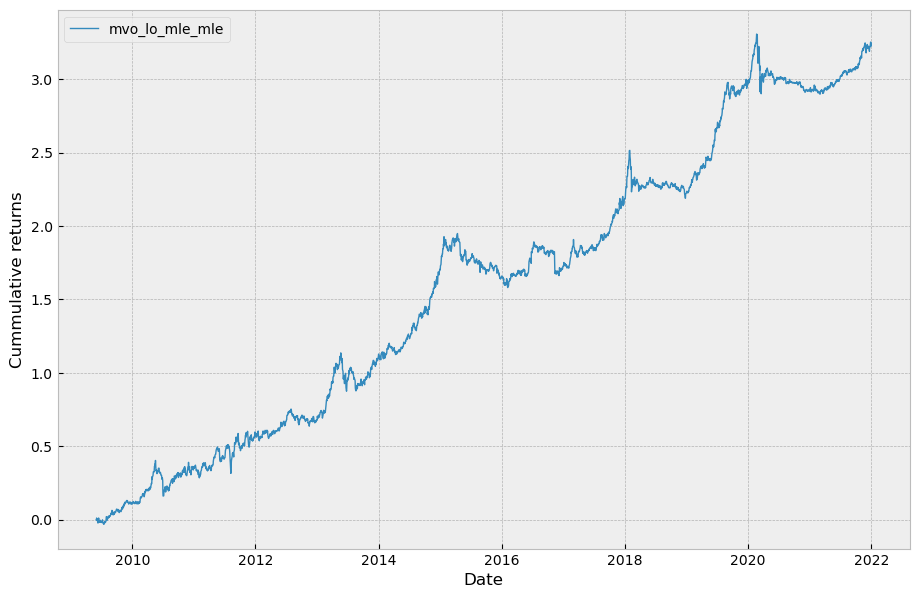

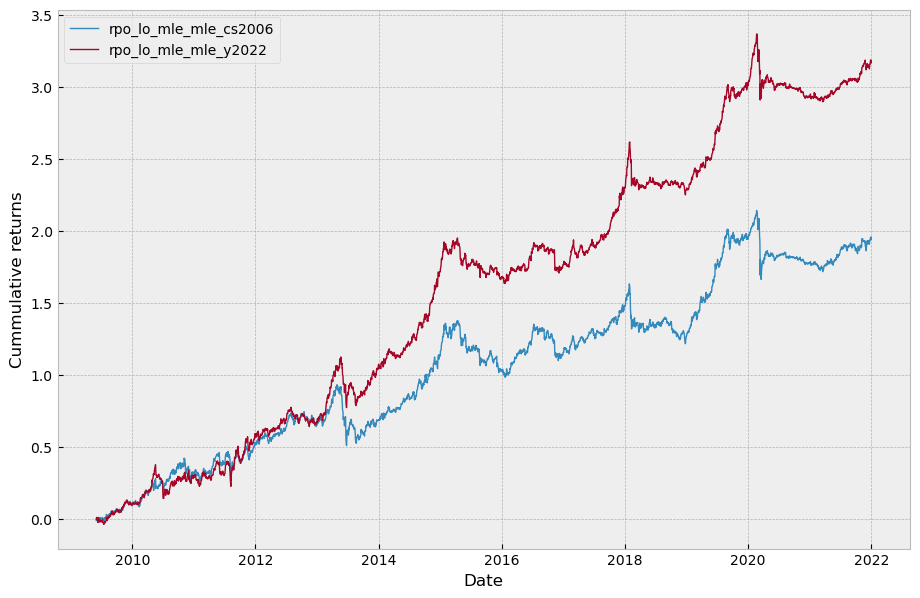

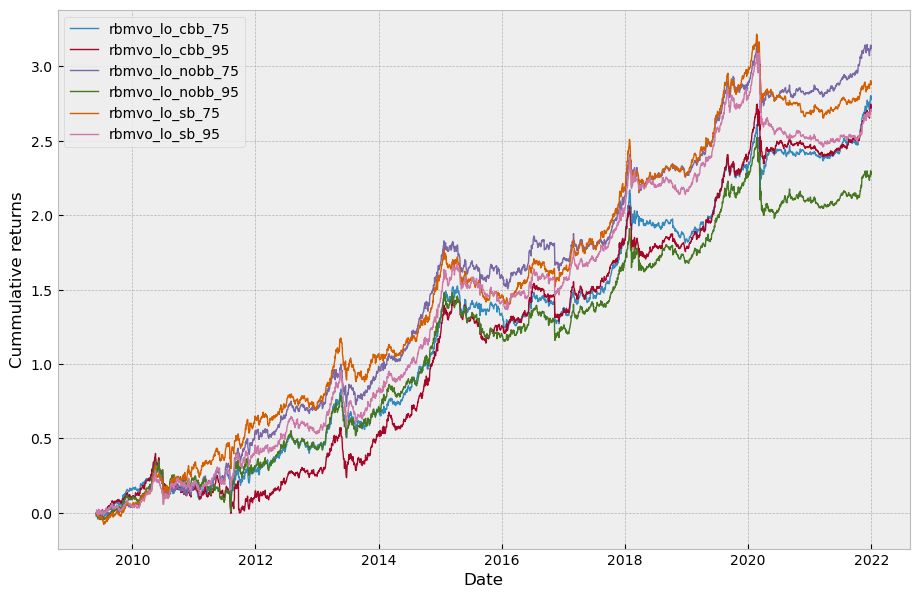

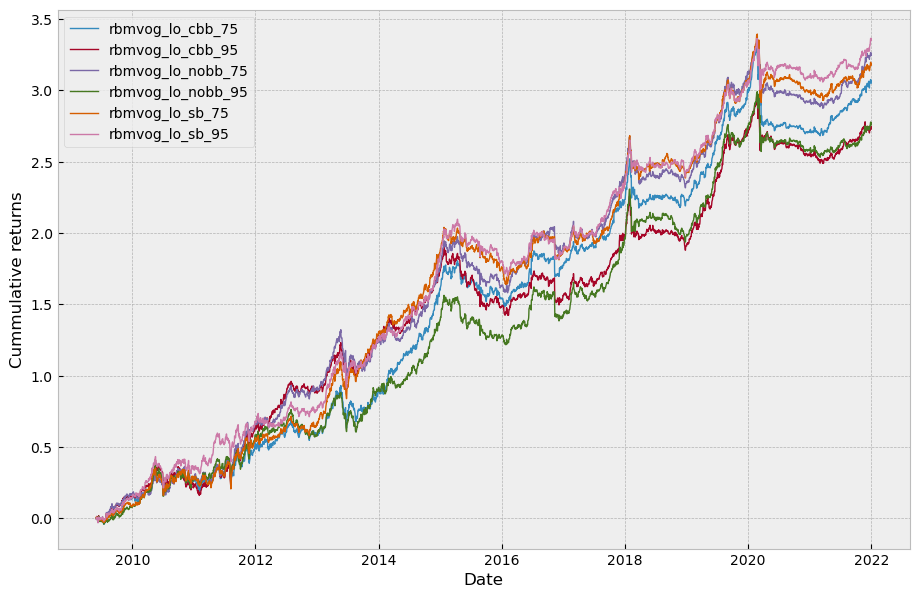

In [73]:
for group in model_group:

    pivot_df = all_summary_df.loc[all_summary_df["model"] == group].pivot_table(index="date", columns="id", values="pnl")
    pivot_df.index = pd.to_datetime(pivot_df.index)

    fig, ax = plt.subplots(figsize=(11, 7))
    for colname in pivot_df.columns:

        portfolio_returns = pivot_df[[colname]]
        portfolio_vol = (portfolio_returns.rolling(window=252).std() * np.sqrt(252)).shift(1)
        portfolio_returns_target = (portfolio_returns * (vol_target / portfolio_vol)).dropna()

        cum_pnl_df = portfolio_returns_target.loc["2009-06-01":].cumsum().reset_index()
        ax.plot(pd.to_datetime(cum_pnl_df['date']), cum_pnl_df[colname], label=colname)

    plt.xlabel("Date")
    plt.ylabel("Cummulative returns")
    plt.legend(loc='best', fontsize=10)   
    fig.savefig(os.path.join(results_path, f"{group}_cummulative_returns_lo.png"), dpi=300)
    plt.show()

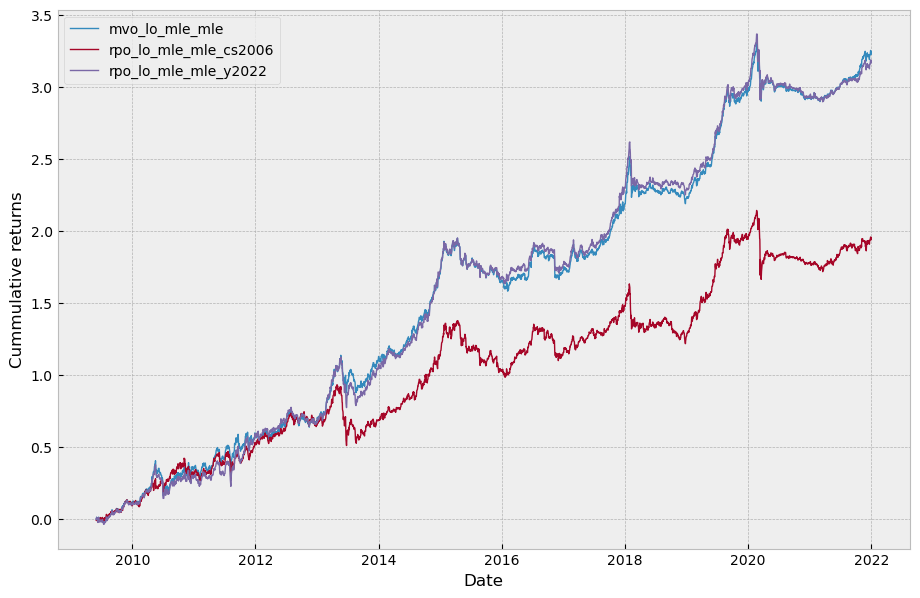

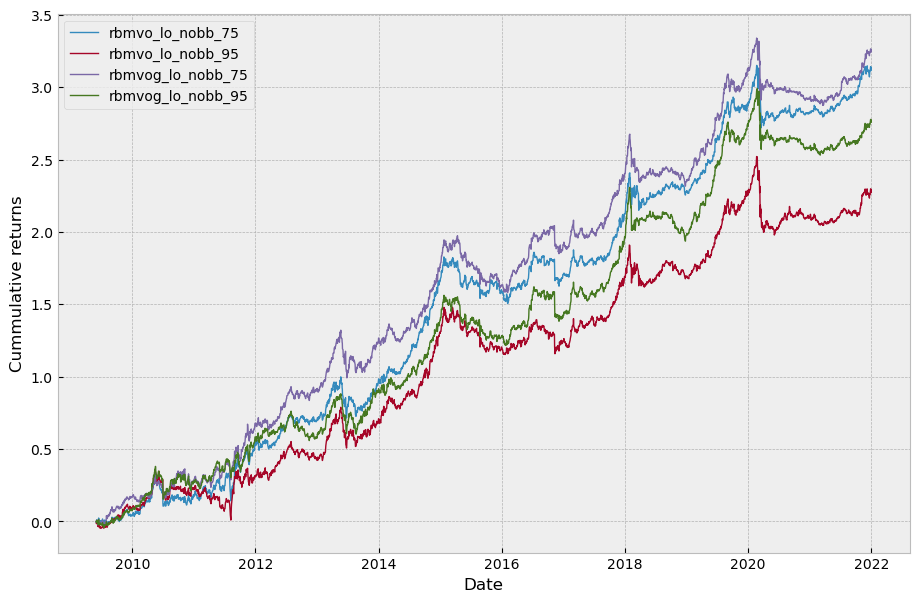

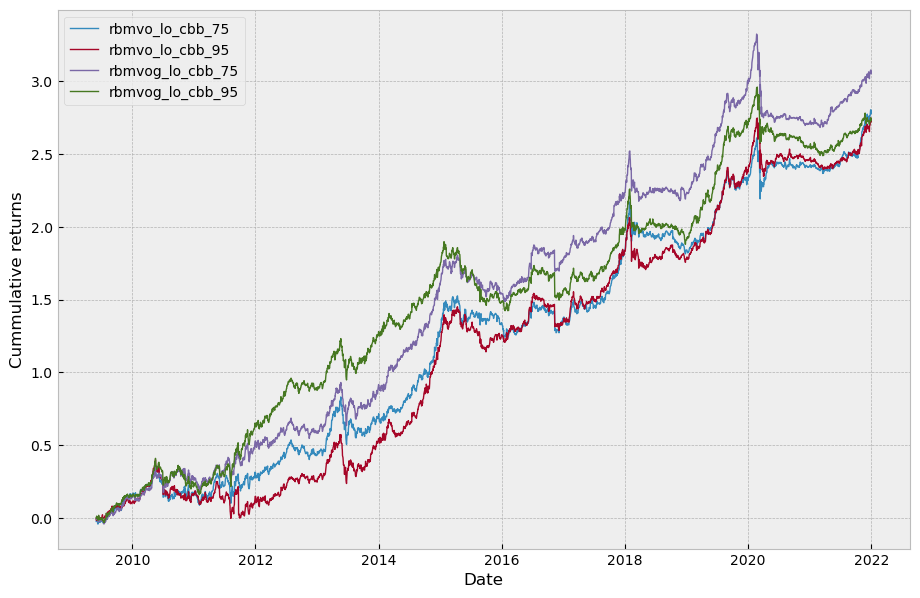

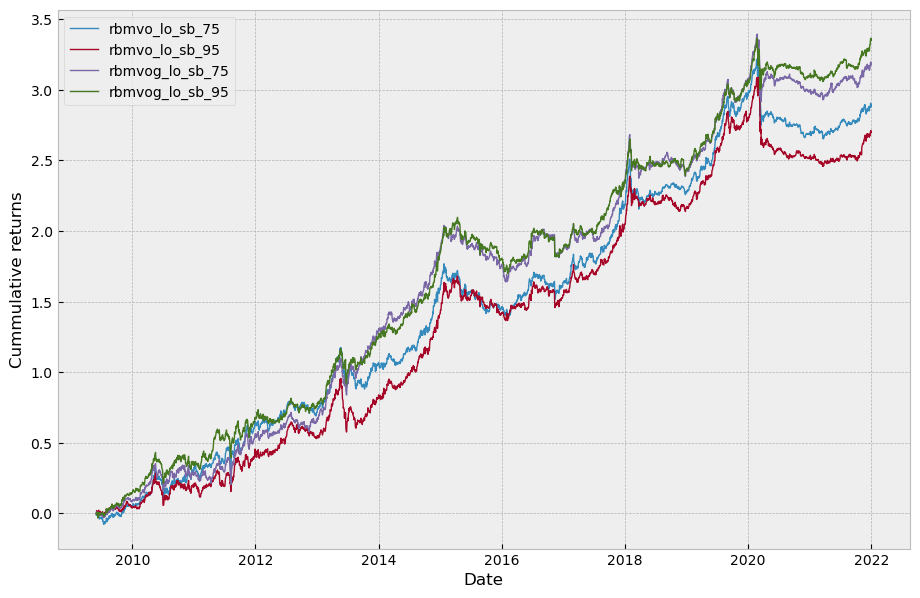

In [59]:
for group in estimator_group:

    pivot_df = all_summary_df.loc[all_summary_df["mean_estimator"] == group].pivot_table(index="date", columns="id", values="pnl")
    pivot_df.index = pd.to_datetime(pivot_df.index)

    fig, ax = plt.subplots(figsize=(11, 7))
    for colname in pivot_df.columns:

        portfolio_returns = pivot_df[[colname]]
        portfolio_vol = (portfolio_returns.rolling(window=252).std() * np.sqrt(252)).shift(1)
        portfolio_returns_target = (portfolio_returns * (vol_target / portfolio_vol)).dropna()

        cum_pnl_df = portfolio_returns_target.loc["2009-06-01":].cumsum().reset_index()
        ax.plot(pd.to_datetime(cum_pnl_df['date']), cum_pnl_df[colname], label=colname)

    plt.xlabel("Date")
    plt.ylabel("Cummulative returns")
    plt.legend(loc='best', fontsize=10)   
    fig.savefig(os.path.join(results_path, f"{group}_cummulative_returns_lo.png"), dpi=300)
    plt.show()

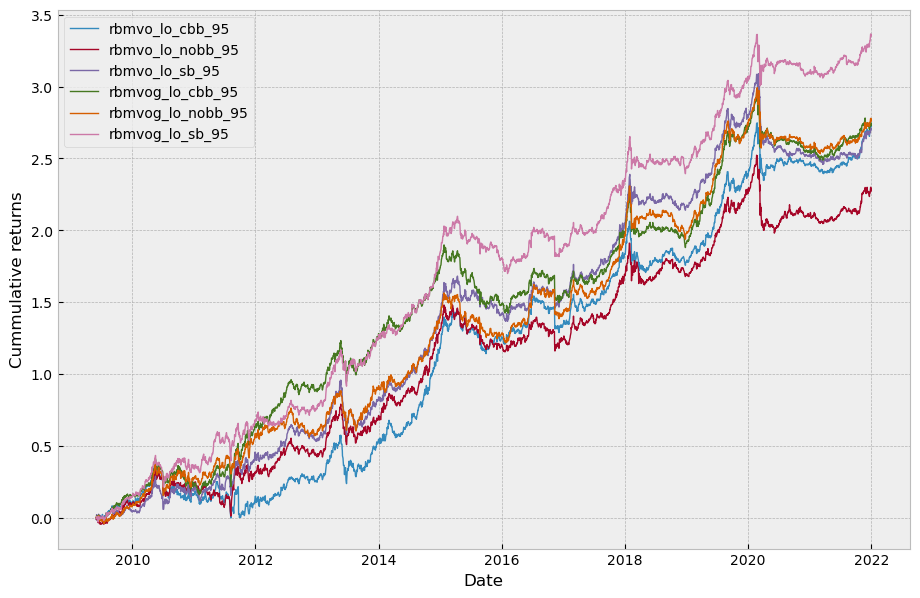

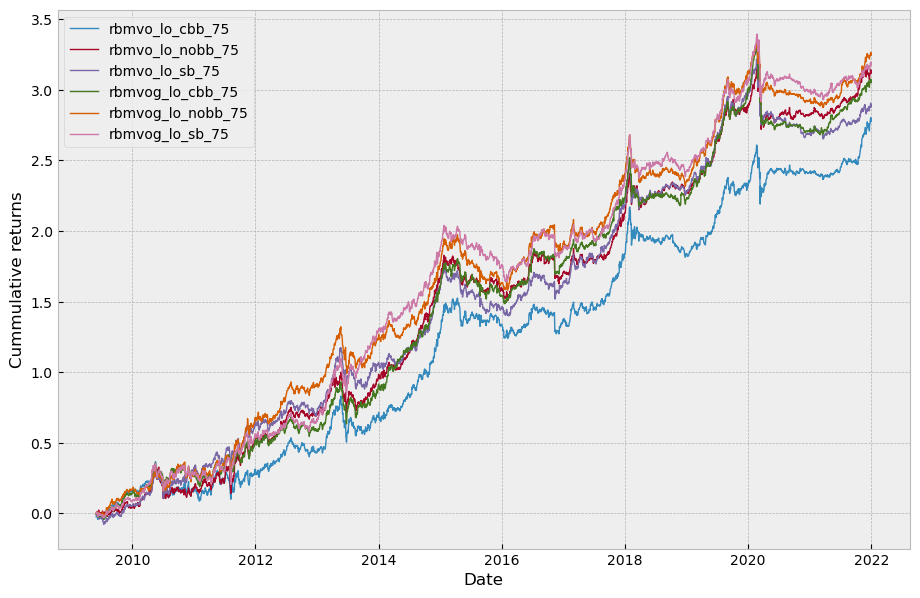

In [60]:
for group in percentile_group:

    pivot_df = all_summary_df.loc[all_summary_df["alpha"] == int(group)/100].pivot_table(index="date", columns="id", values="pnl")
    pivot_df.index = pd.to_datetime(pivot_df.index)

    fig, ax = plt.subplots(figsize=(11, 7))
    for colname in pivot_df.columns:

        portfolio_returns = pivot_df[[colname]]
        portfolio_vol = (portfolio_returns.rolling(window=252).std() * np.sqrt(252)).shift(1)
        portfolio_returns_target = (portfolio_returns * (vol_target / portfolio_vol)).dropna()

        cum_pnl_df = portfolio_returns_target.loc["2009-06-01":].cumsum().reset_index()
        ax.plot(pd.to_datetime(cum_pnl_df['date']), cum_pnl_df[colname], label=colname)

    plt.xlabel("Date")
    plt.ylabel("Cummulative returns")
    plt.legend(loc='best', fontsize=10)   
    fig.savefig(os.path.join(results_path, f"{group}_cummulative_returns_lo.png"), dpi=300)
    plt.show()